In [1]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [2]:
import tensorflow as tf
import os

In [3]:
#avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

# Avoid doggy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = '/content/data/MyDrive/data'

In [6]:
os.listdir(data_dir)

['sad', 'happy']

In [7]:
image_exts=['jpeg','jpg','bmg','png']

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Load data


In [9]:
import numpy as np
from matplotlib import pyplot as plt


In [10]:
data = tf.keras.utils.image_dataset_from_directory('/content/data/MyDrive/data')

Found 305 files belonging to 2 classes.


In [11]:
data_iterator= data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

In [13]:
batch[0].shape #images are represented as numpy arrays

(32, 256, 256, 3)

In [ ]:
batch[1]

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0], dtype=int32)

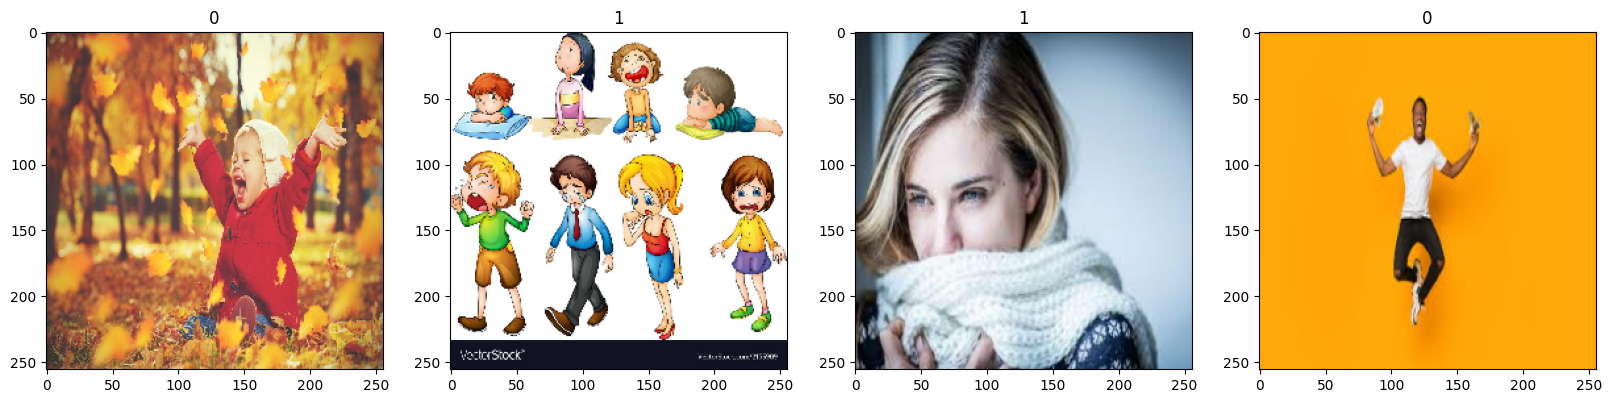

In [14]:
#figure out which is sad and which is happy
# 1--> sad
#0 --> happy
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Preprocessing

In [15]:
# Scale data
data = data.map(lambda x,y:(x/255,y))

In [16]:
scaled_iterator = data.as_numpy_iterator()


In [17]:
batch=scaled_iterator.next()

In [18]:
batch[0].max()

1.0

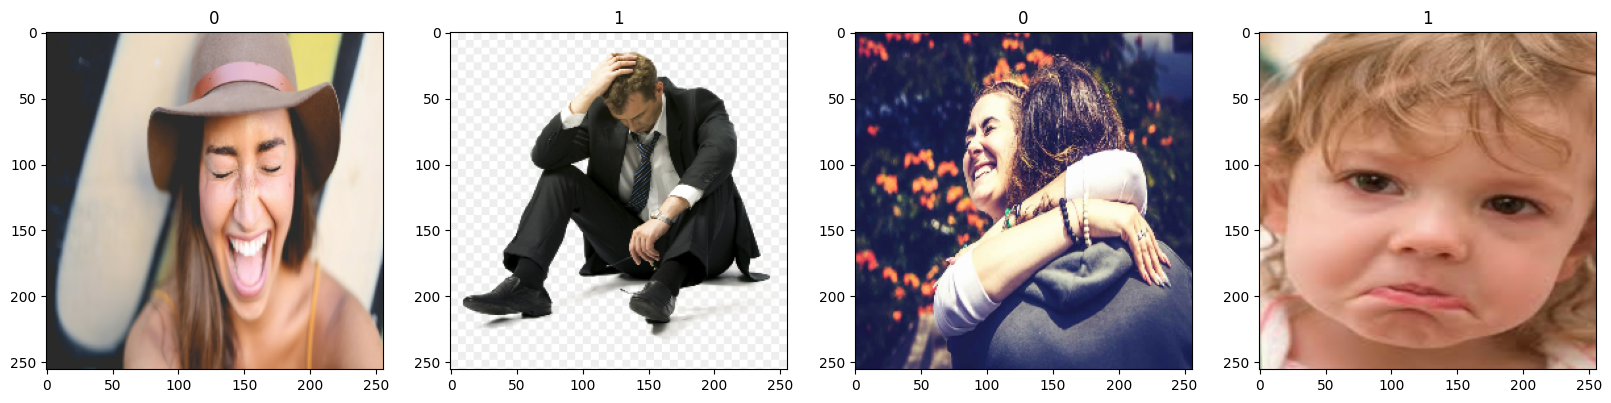

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [20]:
len(data)

10

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [44]:
train = data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size + val_size).take(test_size)

# Building the model

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [47]:
model = Sequential()

In [48]:
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [49]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(), metrics=['Accuracy'])

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

In [31]:
!mkdir logs

In [33]:
logdir='logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [51]:
hist = model.fit(train, epochs=20, validation_data= val,callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 10s 925ms/step - loss: 0.8174 - Accuracy: 0.5580 - val_loss: 0.6309 - val_Accuracy: 0.5312
Epoch 2/20
7/7 [==============================] - 7s 602ms/step - loss: 0.6304 - Accuracy: 0.6250 - val_loss: 0.5846 - val_Accuracy: 0.7969
Epoch 3/20
7/7 [==============================] - 8s 726ms/step - loss: 0.5649 - Accuracy: 0.7321 - val_loss: 0.4159 - val_Accuracy: 0.9375
Epoch 4/20
7/7 [==============================] - 9s 905ms/step - loss: 0.4908 - Accuracy: 0.8080 - val_loss: 0.4548 - val_Accuracy: 0.8281
Epoch 5/20
7/7 [==============================] - 7s 597ms/step - loss: 0.4623 - Accuracy: 0.7545 - val_loss: 0.3432 - val_Accuracy: 0.8125
Epoch 6/20
7/7 [==============================] - 8s 910ms/step - loss: 0.3482 - Accuracy: 0.8661 - val_loss: 0.3475 - val_Accuracy: 0.8750
Epoch 7/20
7/7 [==============================] - 7s 594ms/step - loss: 0.2719 - Accuracy: 0.9330 - val_loss: 0.2100 - val_Accuracy: 0.9375
Epoch 8/20
7/7 [===

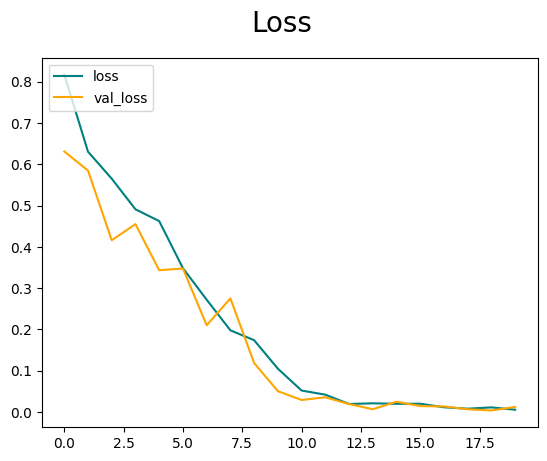

In [52]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal', label='loss')
plt.plot(hist.history['val_loss'],color='orange', label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

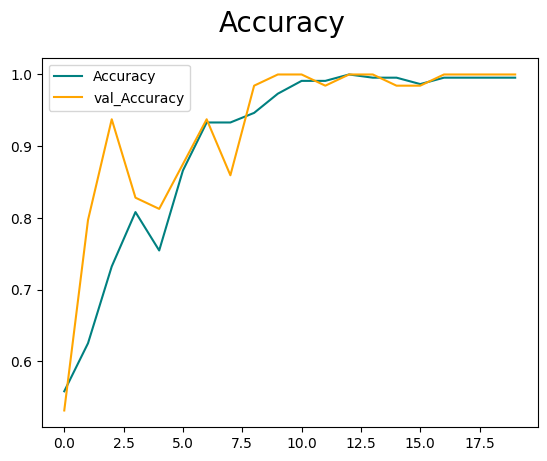

In [53]:
fig=plt.figure()
plt.plot(hist.history['Accuracy'],color='teal', label='Accuracy')
plt.plot(hist.history['val_Accuracy'],color='orange', label='val_Accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

# Testing the model

In [41]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [54]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [55]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 77ms/step


In [56]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
